# Freemarket Code Challenge

**Covers:**
1) Network effect from `Transfers`
2) Fuzzy standardisation of Beneficiaries & Remitters for flow size


In [13]:
%load_ext autoreload
%autoreload 2

import os, sys
import pandas as pd
import matplotlib.pyplot as plt
sys.path.append(os.path.abspath('Code Test'))
from data_io import load_all_tables
from network import build_edge_table, node_metrics, top_connectors
from cleaning import add_canonical_entities, aggregate_flows
from viz import bar_top_series, try_plot_network

excel_path = 'data/Test for Data Science role.xlsx'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
# Load all tables
dfs = load_all_tables(excel_path)
# dfs = ensure_types(dfs)
for k,v in dfs.items():
    print(k, v.shape, list(v.columns)[:8])

client (44, 12) ['hubspotdealid', 'groupname', 'groupcountryincorp', 'companyname', 'companycountryincorp', 'dealstage', 'state', 'riskrating']
accounts (55, 3) ['accountid', 'status', 'hubspotdealid']
deposits (2268, 10) ['depositid', 'accountid', 'londonvaluedate', 'currency', 'amount', 'normalisedamount', 'depositorigin', 'depositremittername']
withdrawals (5868, 9) ['withdrawalid', 'accountid', 'londonvaluedate', 'currency', 'amount', 'normalisedamount', 'beneficiarybankcountry', 'beneficiaryname']
transfers (2452, 10) ['transferid', 'londoncreateddate', 'senderaccountid', 'recipientaccountid', 'currency', 'amount', 'isinterentitytransfer', 'normalisedamount']


## 1) Network effect

In [15]:
edges = build_edge_table(dfs['transfers'])
edges.sort_values('edge_amount', ascending=False).head()

,sender,receiver,edge_txn_count,edge_amount
62,16472,16627,399,8.764210e+08
45,14854,14669,197,1.647358e+08
69,16627,16472,165,6.125971e+07
3,14440,14445,57,6.105975e+07
81,16914,14669,155,5.416830e+07


In [16]:
nodes = node_metrics(edges)
top_nodes = top_connectors(nodes, 20)
top_nodes.head(10)

,client_id,out_degree,in_degree,total_sent,total_received,degree,has_reciprocity,role
12,14462,8.0,9.0,2.979422e+07,3.397851e+07,17.0,True,Hub
34,16627,7.0,6.0,8.065332e+07,9.481957e+08,13.0,True,Hub
3,14445,8.0,5.0,3.807054e+07,7.538979e+07,13.0,True,Hub
31,16472,7.0,4.0,9.217713e+08,6.305111e+07,11.0,True,Broker
9,14459,6.0,5.0,3.028822e+06,1.037999e+07,11.0,True,Hub
2,14440,1.0,5.0,6.105975e+07,3.243213e+07,6.0,True,Broker
23,14857,3.0,3.0,6.319220e+06,1.276058e+06,6.0,True,Member
0,14400,2.0,3.0,1.631523e+07,6.513042e+07,5.0,False,Member
17,14669,1.0,4.0,4.561214e+05,2.651978e+08,5.0,False,Member
7,14456,2.0,3.0,2.308977e+04,2.620894e+05,5.0,True,Member


<Figure size 640x480 with 0 Axes>

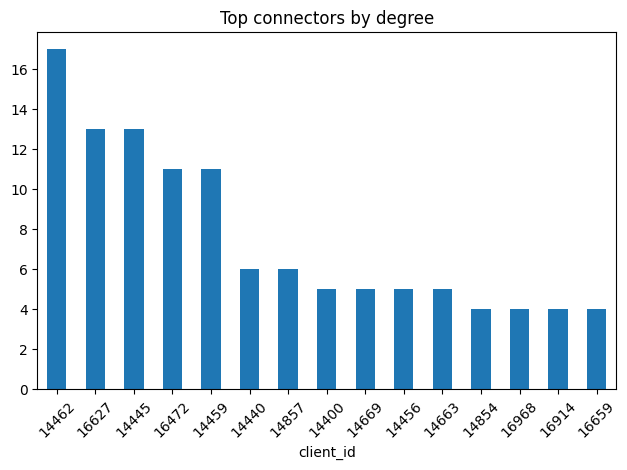

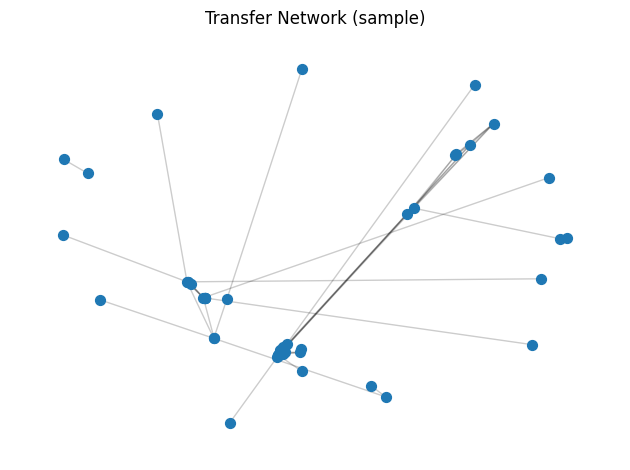

In [17]:
bar_top_series(top_nodes, 'client_id', 'degree', top_n=15, title='Top connectors by degree')
plt.show()
try_plot_network(edges.sample(min(len(edges), 500), random_state=42))

## 2) Outside the Network — Fuzzy standardisation

In [18]:
# Deposits (Remitters)
dep = dfs['deposits'].copy()
dep.columns

Index(['depositid', 'accountid', 'londonvaluedate', 'currency', 'amount',
       'normalisedamount', 'depositorigin', 'depositremittername',
       'depositfeenormalised', 'unnamed: 10'],
      dtype='object')

In [19]:
dep = add_canonical_entities(dep, 'depositremittername', threshold=0.9)
remitter_flows = aggregate_flows(dep, 'depositremittername', 'normalisedamount')
remitter_flows.head(10)

,entity,amount
27,flutterwave ltd,5.844396e+08
47,paystack nigeria ltd,2.077539e+08
33,interswitch ltd,1.234269e+08
38,mpesa safaricom,5.779108e+07
25,flutter wave ng,5.260893e+07
18,dpogroup ltd,5.045639e+07
35,m pesa kenya ltd,4.345047e+07
42,nsano gh ltd,4.018284e+07
41,nsano accra,3.841823e+07
29,flwave lagos,3.470694e+07


In [20]:
# Withdrawals (Beneficiaries)
wd = dfs['withdrawals'].copy()
wd.columns

Index(['withdrawalid', 'accountid', 'londonvaluedate', 'currency', 'amount',
       'normalisedamount', 'beneficiarybankcountry', 'beneficiaryname',
       'withdrawalfeenormalised'],
      dtype='object')

In [21]:
wd = add_canonical_entities(wd, 'beneficiaryname', threshold=0.9)
beneficiary_flows = aggregate_flows(wd, 'beneficiaryname', 'normalisedamount')
beneficiary_flows.head(10)

,entity,amount
8,bitstamp europe s a,5.595569e+08
20,kraken europe ltd,3.215426e+08
2,beneficiary 3,2.917175e+08
14,coinbase europe ltd,1.648157e+08
25,pax os eu,9.606582e+07
18,company 38,7.613253e+07
4,bit stamp lux,7.415377e+07
5,bitpanda gmbh,7.037467e+07
26,paxos europe ltd,5.961942e+07
22,kraken fin de,5.225063e+07


<Figure size 640x480 with 0 Axes>

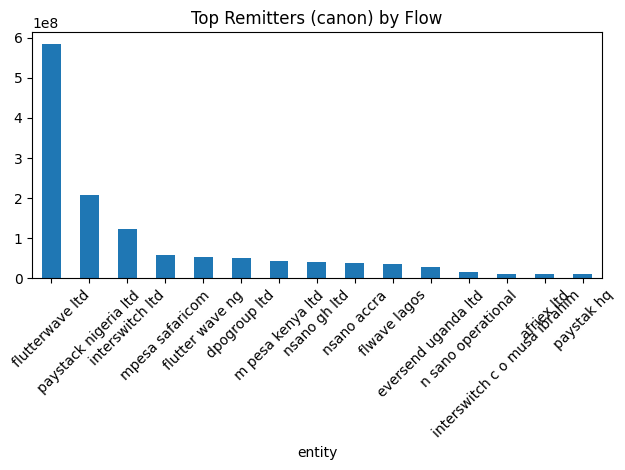

<Figure size 640x480 with 0 Axes>

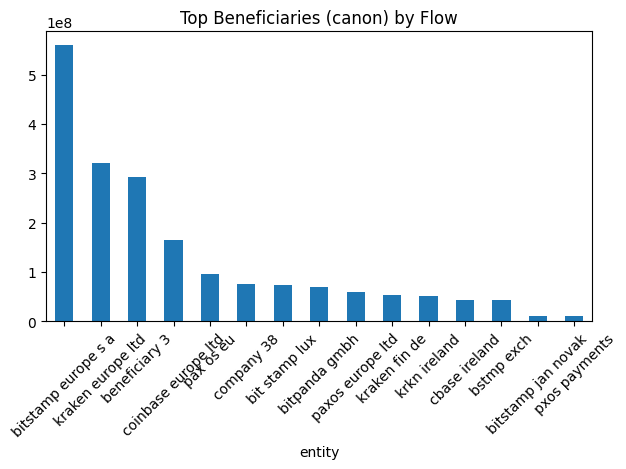

In [22]:
bar_top_series(remitter_flows, 'entity', 'amount', 15, title='Top Remitters (canon) by Flow')
plt.show()
bar_top_series(beneficiary_flows, 'entity', 'amount', 15, title='Top Beneficiaries (canon) by Flow')
plt.show()

### Notes & Findings
- *Hubs* are clients with high in- and out-degree; *Brokers* show asymmetry; *Spokes* have minimal connections.
- Fuzzy grouping uses token normalisation + SequenceMatcher with a high threshold (0.9) to be conservative.